# 1. Метод Гаусса

## 1.1. Метод Гаусса с выбором главного элемента по столбцу

In [8]:
import numpy as np


def gauss_lu_partial_pivot(A, b):
    """
    Solves Ax = b system using Gauss method with selecting pivotal element on column.

   :param A: (n x n) matrix;
   :param b: (n x 1) vector.
   :return: L, U, P: (n x n) matrices so LU = PA, x: (n x 1) solution.
    """

    if A.shape[0] != A.shape[1] or A.shape[0] != b.shape[0]:
        raise ValueError('Wrong parameters shape!')

    A = A.copy()
    b = b.copy()
    n = A.shape[0]

    L = np.eye(n, dtype=float)
    U = A.copy()
    P = np.eye(n, dtype=float)

    for k in range(n):
        pivot = k + np.argmax(np.abs(U[k:, k]))
        if U[pivot, k] == 0:
            raise ValueError("Error: Specific Matrix!")

        if pivot != k:
            U[[k, pivot], :] = U[[pivot, k], :]
            b[[k, pivot]] = b[[pivot, k]]
            P[[k, pivot], :] = P[[pivot, k], :]
            L[:, [k, pivot]] = L[:, [pivot, k]]
            L[[k, pivot], :] = L[[pivot, k], :]

        for i in range(k + 1, n):
            L[i, k] = U[i, k] / U[k, k]
            U[i, :] = U[i, :] - L[i, k] * U[k, :]

    y = np.zeros(n, dtype=float)
    for i in range(n):
        y[i] = b[i]
        for j in range(i):
            y[i] -= L[i, j] * y[j]

    x = np.zeros(n, dtype=float)
    for i in reversed(range(n)):
        x[i] = y[i] / U[i, i]
        for j in range(i + 1, n):
            x[i] -= U[i, j] * x[j] / U[i, i]

    return L, U, P, x

In [9]:
from tqdm import tqdm


def gen_general(size, max_val):
    return (2 * max_val) * np.random.rand(size[0], size[1]) - max_val, (2 * max_val) * np.random.rand(size[1]) - max_val


def test_gauss(t):
    print('Testing Gauss Pivotal method...\n')
    for i in tqdm(range(1, t + 1)):
        n = np.random.randint(1, 1000)
        A_test, b_test = gen_general((n, n), 1e6)

        L, U, P, x_gauss = gauss_lu_partial_pivot(A_test, b_test)
        x_numpy = np.linalg.solve(A_test, b_test)

        error = np.linalg.norm(x_gauss - x_numpy, ord=np.inf)

        print(f"--- Test {i} ---\n--> Size: {n}\n--> Error: {error}\n")


In [10]:
test_gauss(5)

Testing Gauss Pivotal method...



  0%|          | 0/5 [00:00<?, ?it/s]

--- Test 1 ---
--> Size: 99
--> Error: 6.084022174945858e-14

--- Test 2 ---
--> Size: 3
--> Error: 8.881784197001252e-16



 60%|██████    | 3/5 [00:00<00:00,  3.66it/s]

--- Test 3 ---
--> Size: 759
--> Error: 1.5587531265737198e-12



 80%|████████  | 4/5 [00:01<00:00,  2.40it/s]

--- Test 4 ---
--> Size: 759
--> Error: 5.921663159824675e-11



100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

--- Test 5 ---
--> Size: 810
--> Error: 3.7891911830456593e-13



# 2. Итерационные методы решения линейных систем

## 2.1. Метод Ричардсона

In [11]:
def richardson(A, b, tau, max_iter=1000, tol=1e-8):
    """
    Solves Ax = b system using Richardson method.

   :param A: (n x n) matrix;
   :param b: (n x 1) vector.
   :param tau: iteration parameter.
   :param max_iter: maximum number of iterations.
   :param tol: tolerance.
   :return: x: (n x 1) approximate solution, residuals: a list of norms from every iteration.
    """

    if A.shape[0] != A.shape[1] or A.shape[0] != b.shape[0]:
        raise ValueError('Wrong parameters shape!')

    x = np.zeros(len(b))
    residuals = []
    for k in range(max_iter):
        r = A @ x - b
        residuals.append(np.linalg.norm(r))
        if residuals[-1] < tol:
            break
        x = x - tau * r

    return x, residuals


def gershgorin_bounds(A):
    """
    Calculates lower and upper bounds of Eigenvalues of matrix A according to Gershgorin's theorem.

    :param A: (n x n) matrix;
    :return: lambda_min, lambda_max: lower and upper bounds of Eigenvalues of matrix A.
    """

    if A.shape[0] != A.shape[1]:
        raise ValueError('Wrong parameters shape!')

    lambda_min = float('inf')
    lambda_max = -float('inf')

    for i in range(A.shape[0]):
        center = A[i, i]
        radius = np.sum(np.abs(A[i, :])) - abs(A[i, i])

        left = center - radius
        right = center + radius

        if left < lambda_min:
            lambda_min = left
        if right > lambda_max:
            lambda_max = right

    if lambda_min <= 0:
        lambda_min = 1e-15

    return lambda_min, lambda_max

In [31]:
import matplotlib.pyplot as plt
import time


def gen_symmetric(size, max_val):
    ret_a, ret_b = gen_general(size, max_val)
    return ret_a @ ret_a.T, ret_b * ret_b


def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return end - start, result


def test_richardson():
    print('Testing Richardson Iteration method...\n')
    n = np.random.randint(1, 1000)
    A, b = gen_symmetric((n, n), 1)

    eigenvals = np.linalg.eigvals(A)
    lambda_min_estim, lambda_max_estim = gershgorin_bounds(A)
    lambda_min_exact, lambda_max_exact = np.min(eigenvals), np.max(eigenvals)

    print("--- Eigenvalues ---")
    print(f"--> Gershgorin: min: {lambda_min_estim:.6g}, max: {lambda_max_estim:.6g}")
    print(f"--> Exact:      min: {lambda_min_exact:.6g}, max: {lambda_max_exact:.6g}")

    tau_upper_bound = 2.0 / lambda_max_exact
    tau_anyof = 0.5 * tau_upper_bound
    tau_gersh = 2.0 / (lambda_min_estim + lambda_max_estim)
    tau_exact = 2.0 / (lambda_min_exact + lambda_max_exact)

    print("\n--- Tau:")
    print(f"--> Tau Upper Bound: {tau_upper_bound:.6g}")
    print(f"--> Tau Any of:      {tau_anyof:.6g}")
    print(f"--> Tau Gershgorin:  {tau_gersh:.6g}")
    print(f"--> Tau Exact     :  {tau_exact:.6g}")

    max_iter = 10000
    tol = 1e-1

    time_true, x_true = measure_time(np.linalg.solve, A, b)
    time_anyof, (x_anyof, res_anyof) = measure_time(richardson, A, b, tau_anyof, max_iter, tol)
    time_gersh, (x_gersh, res_gersh) = measure_time(richardson, A, b, tau_gersh, max_iter, tol)
    time_exact, (x_exact, res_exact) = measure_time(richardson, A, b, tau_exact, max_iter, tol)

    err_anyof = np.linalg.norm(x_anyof - x_true)
    err_gersh = np.linalg.norm(x_gersh - x_true)
    err_exact = np.linalg.norm(x_exact - x_true)

    print("\n--- Norm |x_approx - x_true| ---")
    print("Any of:     {:.6e}".format(err_anyof))
    print("Gershgorin: {:.6e}".format(err_gersh))
    print("Exact:      {:.6e}".format(err_exact))

    # 6) Время работы
    print("\n--- Time ---")
    print(f"NumPy:      {time_true:.6f} sec")
    print(f"Any of:     {time_anyof:.6f} sec")
    print(f"Gershgorin: {time_gersh:.6f} sec")
    print(f"Exact:      {time_exact:.6f} sec")

    plt.figure(figsize=(8, 6))
    plt.plot(np.log10(res_anyof), label="Tau Any of")
    plt.plot(np.log10(res_gersh), label="Tau Gershgorin")
    plt.plot(np.log10(res_exact), label="Tau Exact")
    plt.xlabel("Iteration")
    plt.ylabel(rf"$\log_{{10}} ||A x_k - b||$")
    plt.title("Richardson approximation")
    plt.grid(True)
    plt.legend()
    plt.show()


Testing Richardson Iteration method...

--- Eigenvalues ---
--> Gershgorin: min: 1e-15, max: 1851.56
--> Exact:      min: 0.000803112, max: 424.249

--- Tau:
--> Tau Upper Bound: 0.00471422
--> Tau Any of:      0.00235711
--> Tau Gershgorin:  0.00108017
--> Tau Exact     :  0.00471421

--- Norm |x_approx - x_true| ---
Any of:     4.437552e+02
Gershgorin: 4.490732e+02
Exact:      4.347032e+02

--- Time ---
NumPy:      0.000676 sec
Any of:     0.194341 sec
Gershgorin: 0.201958 sec
Exact:      0.171776 sec


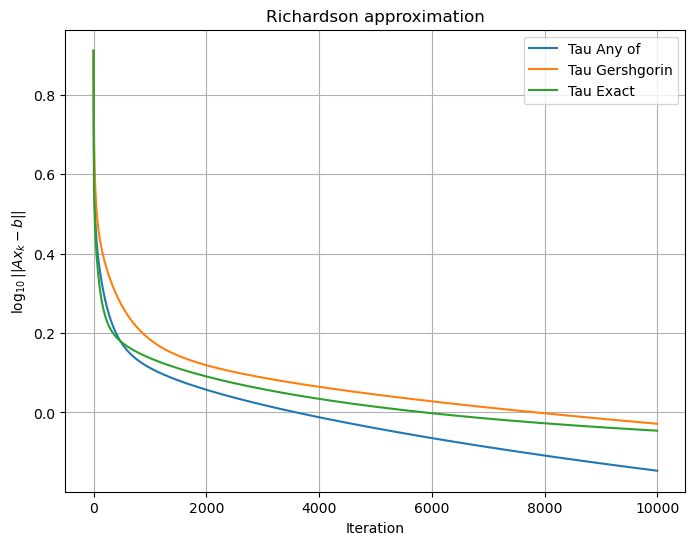

In [32]:
test_richardson()